In [26]:
# Import required libraries
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk.sentiment.vader as vd
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
pd.set_option("display.max_columns", None)
plt.style.use('fivethirtyeight')


In [27]:
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/brightkoech/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
# Load the API keys from the login credential file
log_cred = pd.read_csv("login_credentials.csv")
consumer_key = log_cred.iloc[0, 1]
consumer_secret = log_cred.iloc[1, 1]
access_token = log_cred.iloc[2, 1]
access_token_secret = log_cred.iloc[3, 1]
#print(consumer_key, consumer_secret, access_token, access_token_secret)


In [29]:
# Create the authentication object and the API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [30]:
def get_tweets_by_search_term(search_term, num_tweets):
    data = []
    counter = 0
    query_term = f"{search_term} -filter:retweets"
    for tweet in tweepy.Cursor(
        api.search_tweets,
        q=query_term,
        count=num_tweets,
        lang="en",
        tweet_mode="extended",
    ).items():
        tweet_details = {}
        tweet_details["UserId"] = tweet.user.name
        tweet_details["TweetId"] = tweet.id
        tweet_details["tweet"] = tweet.full_text
        tweet_details["location"] = tweet.user.location
        tweet_details["created"] = tweet.created_at.strftime("%d-%b-%Y")
        data.append(tweet_details)
        counter += 1
        if counter == num_tweets:
            break
        else:
            pass
    data_df = pd.DataFrame(data)
    return data_df

In [31]:
search_term =  input("Enter the search term or hashtag here: ") # Use AND or OR to search for multiple terms
no_of_tweets = int(input("Enter the number of tweets to be searched: "))
data_df = get_tweets_by_search_term(search_term, no_of_tweets)
data_df = data_df.dropna()

In [32]:
# Primary exploratory analysis
print('Dataset shape:', data_df.shape)
print('Dataset columns:', data_df.columns)

Dataset shape: (2000, 5)
Dataset columns: Index(['UserId', 'TweetId', 'tweet', 'location', 'created'], dtype='object')


In [33]:
# After droping duplicates
print('Dataset shape:', data_df.shape)
print('Dataset columns:', data_df.columns)

Dataset shape: (2000, 5)
Dataset columns: Index(['UserId', 'TweetId', 'tweet', 'location', 'created'], dtype='object')


In [34]:
# Drop duplicates
data_df.drop_duplicates(subset='tweet', keep='first', inplace=True)

In [35]:
# Extract the tweets and store them in a dataframe
# Drop all columns except for Tweet and create a list of all words
tweet_df = data_df.drop(['UserId', 'TweetId', 'location', 'created'], axis=1)
tweet_df.head(10)

,tweet
0,@WanjikuHSC Kang'ata is not aware that his photo has been stolen by desperate kuzimia bloggers a...
1,@WycliffeASeven1 @DrAlfredMutua @WilliamsRuto Azimio doesn't play dirty games like your own gach...
2,@StandardKenya Raila left poor Kenyans on the opposition bench where high prices of commodities ...
3,"@HonKangata If Ruto looted moi government,what will he do when he becomes the president,sell our..."
4,"Ruto one minute you are praising the borrowing our government is doing calling it ""responsible"",..."
5,@StandardKenya thanks to william Ruto and MDV for changing the conversation
6,@NationAfrica @chrisdaudi2 Ruto is a total looser.He is totally disoriented.Atwoli was right in ...
7,@HusseinMohamedg Interesting. Last election Uhuru+Ruto+Mutua managed 17% of the votes in Machako...
8,"@MarthaKarua Please rephrase: ""We have a vision to implement the #Bottomup model proposed by #Ru..."
9,@KTNNewsKE Ruto is the best and is offering something new


In [36]:
# Initial cleaning
def clean_tweet(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove @mentions
    text = re.sub(r'#', '', text) # Remove the # in #hashtag
    text = re.sub(r'RT[\s]+', '', text) # Remove RT (retweet)
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove hyperlinks

    return text

tweet_df['tweet'] = tweet_df['tweet'].apply(clean_tweet)
tweet_df.head(10)

,tweet
0,Kang'ata is not aware that his photo has been stolen by desperate kuzimia bloggers and implante...
1,"Azimio doesn't play dirty games like your own gachagua,wainguru ...I come from kambaland..hak..."
2,Raila left poor Kenyans on the opposition bench where high prices of commodities attacked them....
3,"If Ruto looted moi government,what will he do when he becomes the president,sell our kidney??"
4,"Ruto one minute you are praising the borrowing our government is doing calling it ""responsible"",..."
5,thanks to william Ruto and MDV for changing the conversation
6,Ruto is a total looser.He is totally disoriented.Atwoli was right in the warnings he made earl...
7,Interesting. Last election Uhuru+Ruto+Mutua managed 17% of the votes in Machakos County against...
8,"Please rephrase: ""We have a vision to implement the Bottomup model proposed by Ruto and UDA in ..."
9,Ruto is the best and is offering something new


In [37]:
# Tokenize the tweets
tweet_df['tweet'] = tweet_df['tweet'].apply(word_tokenize)
tweet_df.head(10)

,tweet
0,"[Kang'ata, is, not, aware, that, his, photo, has, been, stolen, by, desperate, kuzimia, bloggers..."
1,"[Azimio, does, n't, play, dirty, games, like, your, own, gachagua, ,, wainguru, ..., I, come, fr..."
2,"[Raila, left, poor, Kenyans, on, the, opposition, bench, where, high, prices, of, commodities, a..."
3,"[If, Ruto, looted, moi, government, ,, what, will, he, do, when, he, becomes, the, president, ,,..."
4,"[Ruto, one, minute, you, are, praising, the, borrowing, our, government, is, doing, calling, it,..."
5,"[thanks, to, william, Ruto, and, MDV, for, changing, the, conversation]"
6,"[Ruto, is, a, total, looser.He, is, totally, disoriented.Atwoli, was, right, in, the, warnings, ..."
7,"[Interesting, ., Last, election, Uhuru+Ruto+Mutua, managed, 17, %, of, the, votes, in, Machakos,..."
8,"[Please, rephrase, :, ``, We, have, a, vision, to, implement, the, Bottomup, model, proposed, by..."
9,"[Ruto, is, the, best, and, is, offering, something, new]"


In [38]:
# Remove stop words
additional = ['rt', 'rts', 'r']
def remove_stopwords(tweet):
    stop_words = set(stopwords.words('english') + additional)
    return [word for word in tweet if word not in stop_words]

tweet_df['tweet'] = tweet_df['tweet'].apply(remove_stopwords)
tweet_df.head(10)

,tweet
0,"[Kang'ata, aware, photo, stolen, desperate, kuzimia, bloggers, implanted, crowd, !, Azimio, 're,..."
1,"[Azimio, n't, play, dirty, games, like, gachagua, ,, wainguru, ..., I, come, kambaland, .., haku..."
2,"[Raila, left, poor, Kenyans, opposition, bench, high, prices, commodities, attacked, .., cost, f..."
3,"[If, Ruto, looted, moi, government, ,, becomes, president, ,, sell, kidney, ?, ?]"
4,"[Ruto, one, minute, praising, borrowing, government, calling, ``, responsible, '', ,, next, repr..."
5,"[thanks, william, Ruto, MDV, changing, conversation]"
6,"[Ruto, total, looser.He, totally, disoriented.Atwoli, right, warnings, made, earlier, completely..."
7,"[Interesting, ., Last, election, Uhuru+Ruto+Mutua, managed, 17, %, votes, Machakos, County, SKM+..."
8,"[Please, rephrase, :, ``, We, vision, implement, Bottomup, model, proposed, Ruto, UDA, every, fa..."
9,"[Ruto, best, offering, something, new]"


In [39]:
# Lemmatize the tweets
def lemmatize(tweet):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tweet]

tweet_df['tweet'] = tweet_df['tweet'].apply(lemmatize)
tweet_df.head(10)

,tweet
0,"[Kang'ata, aware, photo, stolen, desperate, kuzimia, blogger, implanted, crowd, !, Azimio, 're, ..."
1,"[Azimio, n't, play, dirty, game, like, gachagua, ,, wainguru, ..., I, come, kambaland, .., hakun..."
2,"[Raila, left, poor, Kenyans, opposition, bench, high, price, commodity, attacked, .., cost, fuel..."
3,"[If, Ruto, looted, moi, government, ,, becomes, president, ,, sell, kidney, ?, ?]"
4,"[Ruto, one, minute, praising, borrowing, government, calling, ``, responsible, '', ,, next, repr..."
5,"[thanks, william, Ruto, MDV, changing, conversation]"
6,"[Ruto, total, looser.He, totally, disoriented.Atwoli, right, warning, made, earlier, completely,..."
7,"[Interesting, ., Last, election, Uhuru+Ruto+Mutua, managed, 17, %, vote, Machakos, County, SKM+R..."
8,"[Please, rephrase, :, ``, We, vision, implement, Bottomup, model, proposed, Ruto, UDA, every, fa..."
9,"[Ruto, best, offering, something, new]"


In [40]:
# Final words after removing stopwords, links and lemmatization
def final_text(words):
    return ' '.join(words)

tweet_df['tweet'] = tweet_df['tweet'].apply(final_text)
tweet_df.head(10)

,tweet
0,Kang'ata aware photo stolen desperate kuzimia blogger implanted crowd ! Azimio 're fighting ghos...
1,"Azimio n't play dirty game like gachagua , wainguru ... I come kambaland .. hakuna kura za Ruto ..."
2,Raila left poor Kenyans opposition bench high price commodity attacked .. cost fuel Soared high ...
3,"If Ruto looted moi government , becomes president , sell kidney ? ?"
4,"Ruto one minute praising borrowing government calling `` responsible '' , next reprehending `` h..."
5,thanks william Ruto MDV changing conversation
6,Ruto total looser.He totally disoriented.Atwoli right warning made earlier completely unhinged D...
7,Interesting . Last election Uhuru+Ruto+Mutua managed 17 % vote Machakos County SKM+Raila+Muthama...
8,Please rephrase : `` We vision implement Bottomup model proposed Ruto UDA every family improve w...
9,Ruto best offering something new


(-0.5, 399.5, 199.5, -0.5)

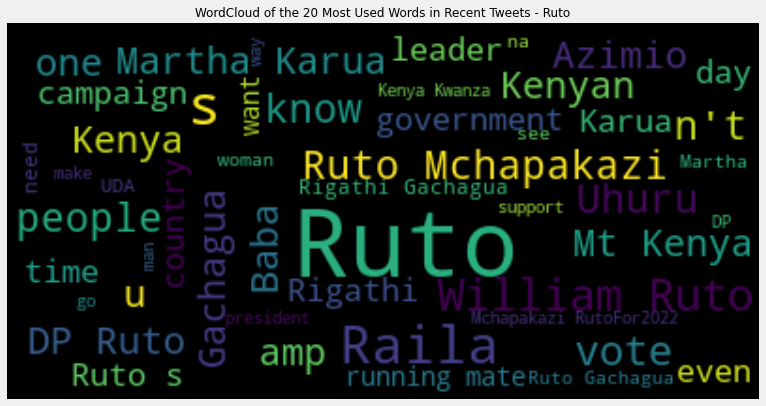

In [41]:
# Wordcloud of the top 100 most used words
all_words = ' '.join([text for text in tweet_df['tweet']])

fig, ax = plt.subplots(figsize=(12, 16))
word_cloud = WordCloud(max_font_size=50, max_words=50, random_state=21).generate(all_words)

ax.imshow(word_cloud, interpolation='bilinear')
ax.set_title(f'WordCloud of the 20 Most Used Words in Recent Tweets - {search_term}', fontsize=12)
ax.axis("off")

In [42]:
# Subjectivity of the tweets using TextBlob
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

tweet_df['subjectivity'] = tweet_df['tweet'].apply(get_subjectivity)
tweet_df['polarity'] = tweet_df['tweet'].apply(get_polarity)
tweet_df.head(10)

,tweet,subjectivity,polarity
0,Kang'ata aware photo stolen desperate kuzimia blogger implanted crowd ! Azimio 're fighting ghos...,0.625000,-0.250000
1,"Azimio n't play dirty game like gachagua , wainguru ... I come kambaland .. hakuna kura za Ruto ...",0.600000,-0.500000
2,Raila left poor Kenyans opposition bench high price commodity attacked .. cost fuel Soared high ...,0.516000,0.104000
3,"If Ruto looted moi government , becomes president , sell kidney ? ?",0.000000,0.000000
4,"Ruto one minute praising borrowing government calling `` responsible '' , next reprehending `` h...",0.573500,-0.338000
5,thanks william Ruto MDV changing conversation,0.200000,0.200000
6,Ruto total looser.He totally disoriented.Atwoli right warning made earlier completely unhinged D...,0.637434,0.147619
7,Interesting . Last election Uhuru+Ruto+Mutua managed 17 % vote Machakos County SKM+Raila+Muthama...,0.482738,0.026786
8,Please rephrase : `` We vision implement Bottomup model proposed Ruto UDA every family improve w...,0.000000,0.000000
9,Ruto best offering something new,0.377273,0.568182


In [43]:
# Compute negative, neutral, positive analysis of the tweets
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score== 0:
        return 'Neutral'
    else:
        return 'Positive'

tweet_df['analysis'] = tweet_df['polarity'].apply(get_analysis)
tweet_df.head(10)

,tweet,subjectivity,polarity,analysis
0,Kang'ata aware photo stolen desperate kuzimia blogger implanted crowd ! Azimio 're fighting ghos...,0.625000,-0.250000,Negative
1,"Azimio n't play dirty game like gachagua , wainguru ... I come kambaland .. hakuna kura za Ruto ...",0.600000,-0.500000,Negative
2,Raila left poor Kenyans opposition bench high price commodity attacked .. cost fuel Soared high ...,0.516000,0.104000,Positive
3,"If Ruto looted moi government , becomes president , sell kidney ? ?",0.000000,0.000000,Neutral
4,"Ruto one minute praising borrowing government calling `` responsible '' , next reprehending `` h...",0.573500,-0.338000,Negative
5,thanks william Ruto MDV changing conversation,0.200000,0.200000,Positive
6,Ruto total looser.He totally disoriented.Atwoli right warning made earlier completely unhinged D...,0.637434,0.147619,Positive
7,Interesting . Last election Uhuru+Ruto+Mutua managed 17 % vote Machakos County SKM+Raila+Muthama...,0.482738,0.026786,Positive
8,Please rephrase : `` We vision implement Bottomup model proposed Ruto UDA every family improve w...,0.000000,0.000000,Neutral
9,Ruto best offering something new,0.377273,0.568182,Positive


In [44]:
def analyse_subjectivity(score):
    if score < 0.5:
        return 'Objective'
    else:
        return 'Subjective'

tweet_df['subjectivity_analysis'] = tweet_df['subjectivity'].apply(analyse_subjectivity)
tweet_df.head(10)

,tweet,subjectivity,polarity,analysis,subjectivity_analysis
0,Kang'ata aware photo stolen desperate kuzimia blogger implanted crowd ! Azimio 're fighting ghos...,0.625000,-0.250000,Negative,Subjective
1,"Azimio n't play dirty game like gachagua , wainguru ... I come kambaland .. hakuna kura za Ruto ...",0.600000,-0.500000,Negative,Subjective
2,Raila left poor Kenyans opposition bench high price commodity attacked .. cost fuel Soared high ...,0.516000,0.104000,Positive,Subjective
3,"If Ruto looted moi government , becomes president , sell kidney ? ?",0.000000,0.000000,Neutral,Objective
4,"Ruto one minute praising borrowing government calling `` responsible '' , next reprehending `` h...",0.573500,-0.338000,Negative,Subjective
5,thanks william Ruto MDV changing conversation,0.200000,0.200000,Positive,Objective
6,Ruto total looser.He totally disoriented.Atwoli right warning made earlier completely unhinged D...,0.637434,0.147619,Positive,Subjective
7,Interesting . Last election Uhuru+Ruto+Mutua managed 17 % vote Machakos County SKM+Raila+Muthama...,0.482738,0.026786,Positive,Objective
8,Please rephrase : `` We vision implement Bottomup model proposed Ruto UDA every family improve w...,0.000000,0.000000,Neutral,Objective
9,Ruto best offering something new,0.377273,0.568182,Positive,Objective


In [45]:
# Compute the number of positive, negative and neutral tweets
tweet_df['analysis'].value_counts()

Neutral     842
Positive    747
Negative    395
Name: analysis, dtype: int64

Text(0.5, 1.0, 'Histogram of the Polarity of the Tweets - Ruto')

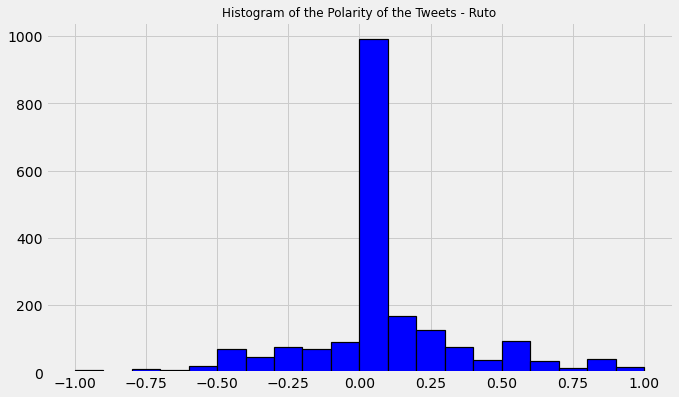

In [46]:
# Plot histogram of the polarity of the tweets
ax0 = tweet_df['polarity'].hist(bins=20, color='blue', edgecolor='black', linewidth=1.2, figsize=(10, 6))
ax0.set_title(f'Histogram of the Polarity of the Tweets - {search_term}', fontsize=12)

Text(0.5, 1.0, 'Analysis of Tweets by Search Term: Ruto')

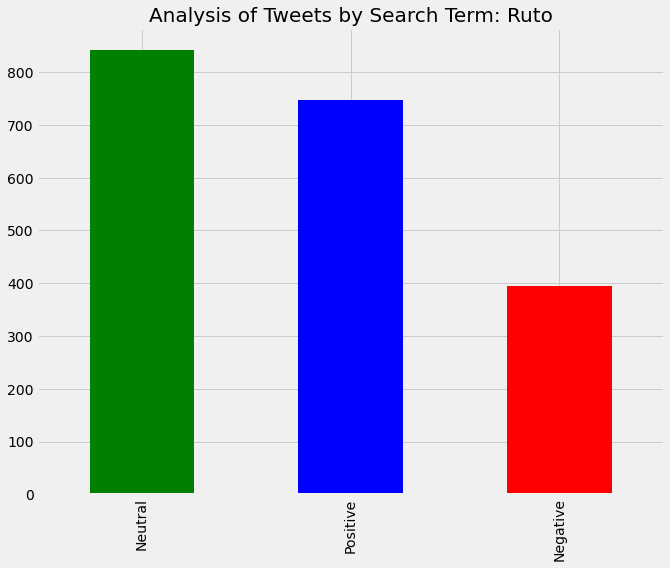

In [47]:
# Plotting the polarity of the tweets
ax1 = tweet_df['analysis'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'], figsize=(10, 8))
ax1.set_title(f'Analysis of Tweets by Search Term: {search_term}', fontsize=20)

Text(0.5, 1.0, '% of Positive, Negative and Neutral Tweets - Ruto')

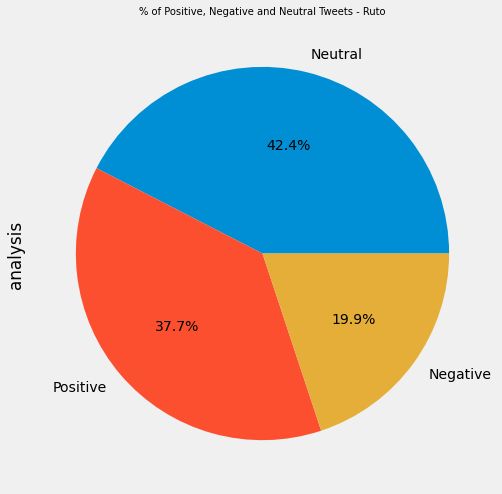

In [48]:
# Pie chart of the polarity of the tweets
ax3 = tweet_df['analysis'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 8))
ax3.set_title(f'% of Positive, Negative and Neutral Tweets - {search_term}', fontsize=10)


Text(0.5, 1.0, '% of Subjective Tweets - Ruto')

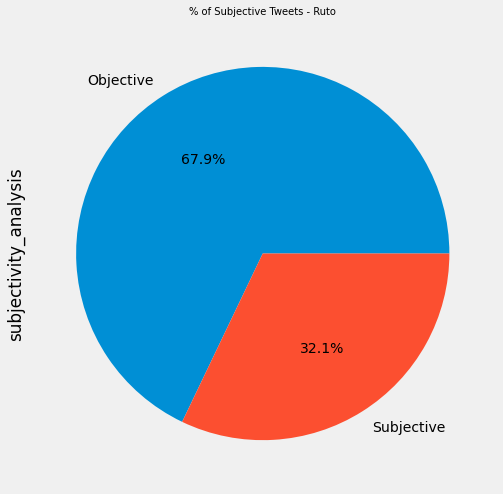

In [49]:
# Pie chart of the subjectivity of the tweets
ax3 = tweet_df['subjectivity_analysis'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10, 8))
ax3.set_title(f'% of Subjective Tweets - {search_term}', fontsize=10)

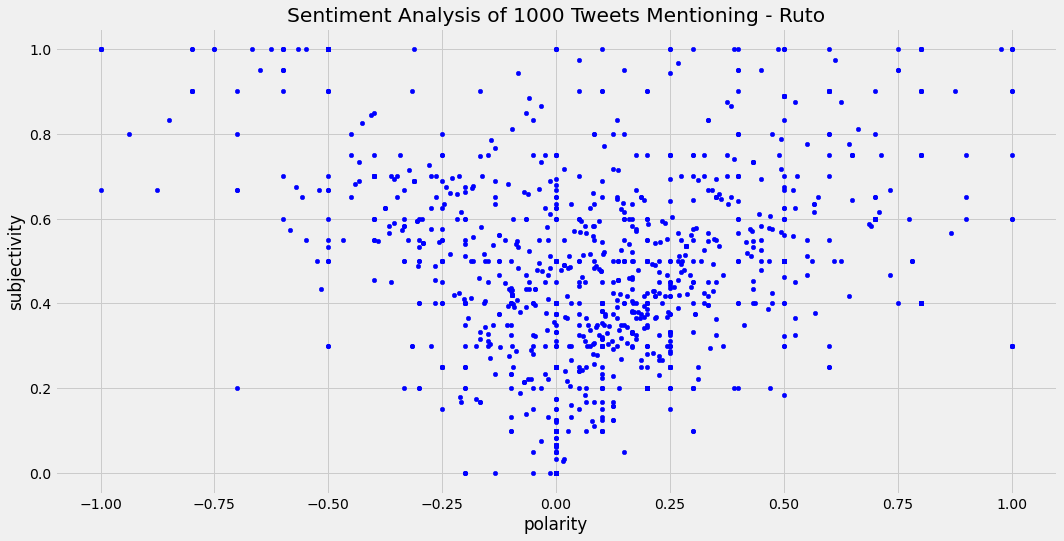

In [50]:
# Plot polarity and subjectivity of the tweets
ax4 = tweet_df.plot(kind='scatter', x='polarity', y='subjectivity', color='blue', figsize=(16,8))
ax4.title.set_text(f'Sentiment Analysis of 1000 Tweets Mentioning - {search_term}')